

```
# Dit is opgemaakt als code
```

# DCGAN to generate grayscale images


## Setup

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import cv2
import random as rd
import PIL

# CHANGE

_____________________________________________________________________

In [2]:
# Image size (height x width)
ih = 128
iw = 128

# Grayscale or RGB
ch = 'grayscale'

# Layer adapt
ksize = 4 # Kernel size : was '4' for 64x64 image
ssize = 2 # Stride size : was '2' for 64x64 image

# Batch size
batch_size = 32

# TPU
print('Are you going to use TPU?')
use_tpu = 'n'

Are you going to use TPU?


_____________________________________________________________________

**TPU Setup (Optional & Automatic)**

In [3]:
if(use_tpu == 'y' or use_tpu == 'Y'):
    # Detect and init. TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

    # Initialize distributed TPU strategy
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [4]:
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.6.2


In [5]:
try: 
    os.mkdir("/kaggle/working/checkpoints")
    print("Path for checkpoints has been created!")
except:
    print("Path already exists")

Path for checkpoints has been created!


In [6]:
try:
    os.mkdir("/kaggle/working/generated_images")
    print("Path for generated images has been created!")
except:
    print("Path already exists")

Path for generated images has been created!


## Prepare CelebA data

We'll use face images from the CelebA dataset, resized to 64x64.

In [7]:
# Overwrite if TPU is used
if use_tpu == 'y' or use_tpu == 'Y':
    batch_size = 16 * tpu_strategy.num_replicas_in_sync

In [8]:
if use_tpu == 'y' or use_tpu == 'Y':
    # Step 1: Get the credentail from the Cloud SDK
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    user_credential = user_secrets.get_gcloud_credential()
    
    # Step 2: Set the credentials
    user_secrets.set_tensorflow_credential(user_credential)
    
    # Step 3: Use a familiar call to get the GCS path of the dataset
    !gcloud config set project 'solid-topic-344315'
    
    GCS_DS_PATH = 'gs://thesis_data_max/classified_data'

    
else: path_root = '/kaggle/input/thesis-data'

Create a dataset from our folder, and rescale the images to the [0-1] range:

In [9]:
im_si = (ih, iw)

if(ch == 'rgb'):
    chnum = 3
elif(ch == 'grayscale'):
    chnum = 1


In [10]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    path_root, 
    label_mode = None,
    color_mode = ch,
    image_size = im_si,
    interpolation='bicubic',
    batch_size = batch_size
)

dataset = dataset.map(lambda x : x / 255.0)

Found 26548 files belonging to 1 classes.


2022-03-19 19:30:40.735421: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 19:30:40.821365: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 19:30:40.822140: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-19 19:30:40.824696: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Let's display a sample image:

## Create the discriminator

It maps a 64x64 image to a binary classification score.

In [11]:
def create_discriminator():
  return keras.Sequential(
      [
        
          layers.Conv2D(ih, kernel_size=ksize, strides=ssize, padding="same",
                        input_shape=(ih, iw, chnum)),
          layers.LeakyReLU(alpha=0.2),
          layers.Conv2D(2*ih, kernel_size=ksize, strides=ssize, padding="same"),
          layers.LeakyReLU(alpha=0.2),
          layers.Conv2D(2*ih, kernel_size=ksize, strides=ssize, padding="same"),
          layers.LeakyReLU(alpha=0.2),
          layers.Flatten(),
          layers.Dropout(0.2),
          layers.Dense(1, activation="sigmoid"),
      ],
      name="discriminator",
  )


## Create the generator

It mirrors the discriminator, replacing `Conv2D` layers with `Conv2DTranspose` layers.

In [12]:
latent_dim = 2*ih
sih = ih//8
siw = iw//8

def create_generator():
  return keras.Sequential(
      [
          keras.layers.InputLayer(input_shape=(latent_dim)),
          
          layers.Dense(sih * siw * latent_dim),
          layers.Reshape((sih, siw, latent_dim)),
          layers.Conv2DTranspose(latent_dim, kernel_size=ksize, strides=ssize, padding="same"),
          layers.LeakyReLU(alpha=0.2),
          layers.Conv2DTranspose(2*latent_dim, kernel_size=ksize, strides=ssize, padding="same"),
          layers.LeakyReLU(alpha=0.2),
          layers.Conv2DTranspose(4*latent_dim, kernel_size=ksize, strides=ssize, padding="same"),
          layers.LeakyReLU(alpha=0.2),
          layers.Conv2D(chnum, kernel_size=ksize+1, padding="same", activation="sigmoid"),
      ],
      name="generator",
  )


In [13]:
if use_tpu == 'y' or use_tpu == 'Y':
    with tpu_strategy.scope():
        generator = create_generator()
        discriminator = create_discriminator()
else:  
    generator = create_generator()
    discriminator = create_discriminator()

## Override `train_step`

In [14]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }
  


**Other GAN Script**

In [15]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [16]:
def discriminator_loss(real_output, fake_output, d_loss):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    d_loss.append(total_loss)
    return total_loss

In [17]:
def generator_loss(fake_output, g_loss):
    fake_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    g_loss.append(fake_loss)
    return fake_loss

In [18]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [19]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 128)       2176      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 256)       524544    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 256)       1048832   
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
flatten (Flatten)            (None, 65536)           

In [20]:
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 65536)             16842752  
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 256)       1048832   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 64, 64, 512)       2097664   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 512)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 128, 128, 1024)    83

## Create a callback that periodically saves generated images

In [21]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        start = time.time()
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("/kaggle/working/generated_images/generated_img_%03d_%d.png" % (epoch, i))
    
        # Save the model every 15 epochs (WAS 15)
        if (epoch + 1) % 15 == 0:
          checkpoint.save(file_prefix = checkpoint_prefix)



**Restore checkpoints if they exists**

In [22]:
checkpoint_dir = '/kaggle/working/checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=create_generator(),
                                 discriminator=create_discriminator())

In [23]:
checkpoint_directory = '/kaggle/input/dcgan-tweaking-kaggle/checkpoints'

In [24]:
if(os.path.exists(checkpoint_directory)):
    print("A checkpoint was found!")
    ckpt_exists = True
else: 
    print("Checkpoitn was not found!")
    chpt_exists = False

A checkpoint was found!


In [25]:
if ckpt_exists == True:
    epochs = 16
    chkpt_restore_path = tf.train.latest_checkpoint(checkpoint_directory)
    print(chkpt_restore_path)
    num_ckpt = chkpt_restore_path[-1:]
    checkpoint.restore(chkpt_restore_path)

/kaggle/input/dcgan-tweaking-kaggle/checkpoints/ckpt-1


In [26]:
   if ckpt_exists == True:
    if use_tpu == 'y' or use_tpu == 'Y':
        with tpu_strategy.scope():
            gan = GAN(discriminator=checkpoint.discriminator, generator=checkpoint.generator, latent_dim=latent_dim)

            gan.compile(
            d_optimizer=keras.optimizers.Adam(learning_rate=0.0001), # Was 0.0001
            g_optimizer=keras.optimizers.Adam(learning_rate=0.0001), # Was 0.0001
            loss_fn=keras.losses.BinaryCrossentropy(),
            )

    else: 
        gan = GAN(discriminator=checkpoint.discriminator, generator=checkpoint.generator, latent_dim=latent_dim)

        gan.compile(
        d_optimizer=keras.optimizers.Adam(learning_rate=0.0001), # Was 0.0001
        g_optimizer=keras.optimizers.Adam(learning_rate=0.0001), # Was 0.0001
        loss_fn=keras.losses.BinaryCrossentropy(),
        )

    #steps_per_epoch = 2500 // batch_size
    gan.fit(
      dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
    )

2022-03-19 19:30:46.414435: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/16


2022-03-19 19:30:49.954322: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


830/830 [==============================] - 1231s 1s/step - d_loss: 0.2831 - g_loss: 7.6382
Epoch 2/16
830/830 [==============================] - 1214s 1s/step - d_loss: 0.0413 - g_loss: 13.0433
Epoch 3/16
830/830 [==============================] - 1213s 1s/step - d_loss: -0.0388 - g_loss: 154.0682
Epoch 4/16
830/830 [==============================] - 1210s 1s/step - d_loss: -5.2556 - g_loss: 861.7755
Epoch 5/16
830/830 [==============================] - 1204s 1s/step - d_loss: -130.9112 - g_loss: 26818.1758
Epoch 6/16
830/830 [==============================] - 1205s 1s/step - d_loss: -993.8783 - g_loss: 142118.7812
Epoch 7/16
830/830 [==============================] - 1201s 1s/step - d_loss: -962.2100 - g_loss: 183882.0312
Epoch 8/16
830/830 [==============================] - 1203s 1s/step - d_loss: -1995.6499 - g_loss: 507323.5000
Epoch 9/16
830/830 [==============================] - 1203s 1s/step - d_loss: -4269.9248 - g_loss: 690111.8750
Epoch 10/16
830/830 [========================

## Train the end-to-end model

In [27]:
if ckpt_exists == False:
    epochs = 16  # In practice, use ~100 epochs

    if use_tpu == 'y' or use_tpu == 'Y':
        with tpu_strategy.scope():
            gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

            gan.compile(
            d_optimizer=keras.optimizers.Adam(learning_rate=0.0001), # Was 0.0001
            g_optimizer=keras.optimizers.Adam(learning_rate=0.0001), # Was 0.0001
            loss_fn=keras.losses.BinaryCrossentropy(),
            )

    else: 
        gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

        gan.compile(
        d_optimizer=keras.optimizers.Adam(learning_rate=0.0001), # Was 0.0001
        g_optimizer=keras.optimizers.Adam(learning_rate=0.0001), # Was 0.0001
        loss_fn=keras.losses.BinaryCrossentropy(),
        )

    #steps_per_epoch = 2500 // batch_size
    gan.fit(
      dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
    )

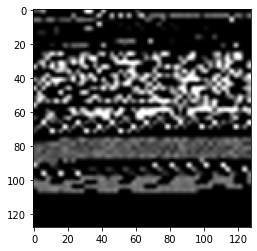

In [28]:
for x in dataset:
  i = rd.randint(0,26458)
  plt.imshow((x.numpy() * 255).astype("int32")[0], cmap='gray')
  break

Some of the last generated images around epoch 30
(results keep improving after that):


# Checkpoint Restore